### 0. Описание

---
В данном ноутбуке содержится код алгоритма предсказания поисковой выдачи.
Алгоритм довольно простой:
* на исторических запросах строится TF-IDF индекс слов, биграмм и триграмм
* описание товаров и значение их атрибутов объединяются в одно суммарное описание
* суммарное описание каждого товара прогоняется через построенный индекс
* к каждому запросу ищутся топ-25 релевантных товаров по скалярному произведению векторных представлений

---
Данный код не идеален и ему требуется внимание знающего человека.
Подробнее об этом в каждом из пунктов этого ноутбука.

__nB!__ Для выполнения данного задания должны быть установлены библиотеки `numpy`, `pandas`, `matplotlib`, `joblib`, а так же `scikit-learn`. Версии указаны в _requirements.txt_.

Данный ноутбук может быть выполнен в его текущем состоянии от начала и до конца, поэтому пункты можно решать не последовательно.

Однако для того чтобы приступить к некоторым пунктам, сначала необходимо прогнать ячейки с кодом предыдущих.

Все ячейки кроме пустых заблокированы для редактирования, не стесняйтесь создавать новые.

### 1. Рефакторинг полотен кода

В этом задании нужно проявить себя как программиста и найти неэффективные части кода как по памяти, так и по времени исполнения; также в коде присутствуют плохо структурированные части, в конце концов есть даже баг (!).

_Hint:_ Представьте, что вам нужно добавить этот код в свою библиотеку и использовать раз за разом.

---

Результатом выполнения данного задания может быть как с нуля написанный код, так и оптимизированная версия приведённого.

Данное задание позволяет оценить бэкграунд кандидата, его знание питона, умение структурировать свой код и читать чужой.

---

#### Описание
В качестве входных данных нам поступает tsv-файл (tab separated values), в котором присутствует колонка `search_term`.
Значения из этой колонки являются поисковыми запросами пользователей.

Нам хочется научиться считать [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) вектора для таких запросов. (не используя сторонних библиотек, конечно же)

Прежде чем подсчитывать встречаемость слов, мы приводим все слова к нижнему регистру, удаляем пунктуацию и слова состоящие из одних лишь цифр.

Помимо обычных слов, мы добавляем в словарь токенов биграммы и триграммы.

Чтобы не "раздувать" словарь токенов, для слов, биграмм и триграмм мы вводим отдельные границы встречаемости.
Таким образом, если слово встречалось менее чем в 50 запросах, то оно не попадает в итоговый словарь. Для биграмм и триграмм границы соответственно 25 и 10.

Первая функция возвращает пару словарей: в первом находится отображение токенов в индексы внутри вектора, во втором -- частота встречаемости токенов в запросах.

Вторая функция принимает запрос пользователя в виде непредобработанной строки, словари из первой функции и возвращает вектор TF-IDF для данного запроса.

In [1]:
from string import punctuation
from math import log

LIMITS = {
    1: 50,
    2: 25,
    3: 10,
}

def build_tfidf_index(filename):
    with open(filename) as file:
        lines = file.readlines()
    header, lines = lines[0], lines[1:]
    sentence_idx = header.rstrip('\n').split('\t').index('search_term')
    sentences = [line.rstrip('\n').split('\t')[sentence_idx] for line in lines]

    new_sentences = []
    for sentence in sentences:
        words = sentence.split(' ')
        new_words = []
        for word in words:
            new_word = ''
            for char in word:
                if char not in punctuation:
                    new_word += char.lower()
            if new_word != '' and not new_word.isnumeric():
                new_words.append(new_word)
        new_sentences.append(new_words)

    word_count = dict()
    for sentence in new_sentences:
        for word in sentence:
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] += 1

    bigram_count = dict()
    for sentence in new_sentences:
        for i in range(len(sentence)-1):
            bigram = sentence[i] + '_' + sentence[i+1]
            if bigram not in bigram_count:
                bigram_count[bigram] = 1
            else:
                bigram_count[bigram] += 1

    trigram_count = dict()
    for sentence in new_sentences:
        for i in range(len(sentence)-2):
            trigram = sentence[i] + '_' + sentence[i+1] + '_' + sentence[i+2]
            if trigram not in trigram_count:
                trigram_count[trigram] = 1
            else:
                trigram_count[trigram] += 1

    log_nsents = log(len(sentences))
    idf = {}
    for word, count in word_count.items():
        if count > LIMITS[1]:
            idf[word] = log_nsents - log(count)
    for bigram, count in bigram_count.items():
        if count > LIMITS[2]:
            idf[bigram] = log_nsents - log(count)
    for trigram, count in trigram_count.items():
        if count > LIMITS[3]:
            idf[trigram] = log_nsents - log(count)

    index = {}
    for i, key in enumerate(idf.keys()):
        index[key] = i

    return index, idf

In [2]:
import numpy as np

def build_tfidf_vector(sentence, index, idf):
    words = sentence.split(' ')
    new_words = []
    for word in words:
        new_word = ''
        for char in word:
            if char not in punctuation:
                new_word += char.lower()
        if new_word != '' and not new_word.isnumeric():
            new_words.append(new_word)

    counts = {}
    for word in new_words:
        counts[word] = new_words.count(word)

    bigrams = []
    for i in range(len(new_words)-1):
        bigrams.append(new_words[i] + '_' + new_words[i+1])
    for bigram in bigrams:
        counts[bigram] = bigrams.count(bigram)

    trigrams = []
    for i in range(len(new_words)-2):
        trigrams.append(new_words[i] + '_' + new_words[i+1] + '_' + new_words[i+2])
    for trigram in trigrams:
        counts[trigram] = trigrams.count(trigram)

    n_tokens = sum(map(len, [new_words, bigrams, trigrams]))
    tfidf_values = {}
    for token, count in counts.items():
        if token in idf:
            tf = count / n_tokens
            tfidf_values[token] = tf * idf[token]

    vector = np.zeros(len(index))
    for key, tfidf in tfidf_values.items():
        if key in index:
            vector[index[key]] = tfidf

    return vector

Ожидается, что результатом оптимизации будут функции с такими же названиями и такими же аргументами как и у исходных.

In [3]:
# your code here

In [4]:
from functools import partial

token_index, token_idf = build_tfidf_index('train.tsv')

build_tfidf = partial(build_tfidf_vector, index=token_index, idf=token_idf)

### 2. Работа с `pandas`

Задача состоит в том, чтобы переписать ячейку кода с чистым питоном, используя методы `pandas.DataFrame`.

В данной ячейке считываются два csv файла: _attributes.csv_ и <i>product_descriptions.csv</i>, их содержимое объединяется по колонке `product_uid`.

В результате получается словарь с ключом `product_uid` и значением, в котором находится объединение описания и значений атрибутов товара.

In [5]:
from tqdm import tqdm

attr_file = 'attributes.csv'
pdsc_file = 'product_descriptions.csv'

In [6]:
%%time

import csv


def read_csv(filename, columns):
    with open(filename) as file:
        lines = file.readlines()
    lines = [l for l in csv.reader(lines)]
    header, lines = lines[0], lines[1:]
    col_idxs = [header.index(col) for col in columns]
    return [[line[c_idx] for c_idx in col_idxs] for line in lines]

joint_description = {key: value for key, value in read_csv(pdsc_file, ['product_uid', 'product_description'])}

product_attributes = read_csv(attr_file, ['product_uid', 'value'])

for product_uid, attr_value in product_attributes:
    if product_uid not in joint_description:
        joint_description[product_uid] = attr_value
    else:
        joint_description[product_uid] += ' ' + attr_value

CPU times: user 5.96 s, sys: 256 ms, total: 6.22 s
Wall time: 6.22 s


In [7]:
# your code here

### 3. Ускорение вычислений (знакомство с новыми библиотеками?..)

Данное задание возможно самое простое из всех: перепишите процедуру вычисления векторов товаров и запросов с использованием библиотеки [`joblib`](https://joblib.readthedocs.io/en/latest/).

Данная библиотека позволяет обойти ограничение питона на выполнение в одном потоке.

In [8]:
import pandas as pd

searches = pd.read_csv('train.tsv', sep='\t', usecols=['search_term'])['search_term'].unique()

In [9]:
from itertools import islice
import numpy as np

product_vectors = np.zeros((len(joint_description), len(token_index)))
index_to_product = {}

for i, (product_uid, description) in enumerate(tqdm(joint_description.items(), desc='Products')):
    index_to_product[i] = product_uid
    product_vectors[i] = build_tfidf(description)

search_vectors = np.zeros((len(searches), len(token_index)))
for i, search in enumerate(tqdm(searches, desc='Searches')):
    search_vectors[i] = build_tfidf(search)

Searches: 100%|██████████| 11795/11795 [00:00<00:00, 71605.51it/s]


In [10]:
# your code here

### 4. Оптимизация `numpy` кода

В данном задании вам предлагается придумать как можно ускорить функцию `get_topk`, написанную с помощью `numpy`.

Для этого вы можете использовать все доступные и знакомые вам методы.

In [11]:
product_to_index = {pid: idx for idx, pid in index_to_product.items()}

def get_relevance(search_idx, candidates):
    product_idxs = [product_to_index[pid] for pid in candidates]
    return product_vectors[product_idxs] @ search_vectors[search_idx]

In [12]:
def get_topk(queries, products):
    topk_idxs = [None,] * queries.shape[0]
    for i, seed in tqdm(enumerate(queries), total=queries.shape[0]):
        scores = (products @ seed.T)
        cur_topk = np.argsort(scores)[-25:][::-1]
        topk_idxs[i] = (cur_topk.tolist(), scores[cur_topk].tolist())
    return topk_idxs

In [13]:
%%time

topk_prediction = get_topk(search_vectors[:400], product_vectors)

100%|██████████| 400/400 [00:56<00:00,  6.95it/s]

CPU times: user 5min 7s, sys: 1min 9s, total: 6min 17s
Wall time: 56 s


Подсказки:
* TF-IDF векторы имеют большую размерность, однако бОльшая часть значений в них заполнена нулями;

* для выполнения матричных операций `numpy` использует все ядра процессора;

* Предыдущими подсказками возможности оптимизации не ограничиваются.

In [14]:
# your code here

---
После того как `get_topk` оптимизируется, можно будет предсказать топ-25 товаров для каждого запроса, а не только для первых 400.

In [15]:
# topk_prediction = get_topk(search_vectors, product_vectors)

### 5. Работа с `matplotlib`

In [16]:
from operator import itemgetter as at

def read_relevance(filename='train.tsv'):
    relevance_dict = {}
    with open(filename) as file:
        lines = file.readlines()
    values = (line.rstrip('\n').split('\t') for line in lines)
    header = next(values)
    getter = at(*map(header.index, ['search_term', 'product_uid', 'relevance']))
    for s_term, p_uid, rel in map(getter, values):
        relevance_dict[s_term] = relevance_dict.get(s_term, []) + [(p_uid, float(rel))]
    return relevance_dict

relevance_dict = {s_term: dict(pairs) for s_term, pairs in read_relevance().items()}

В `relevance_dict` содержатся словари `product_uid`: `relevance` для каждого запроса.

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

---
Используя свои знания `matplotlib` выведите гистограмму количества товаров для каждого из доступных запросов в `relevance_dict`.

#### <center>Референсный график</center>
<img src="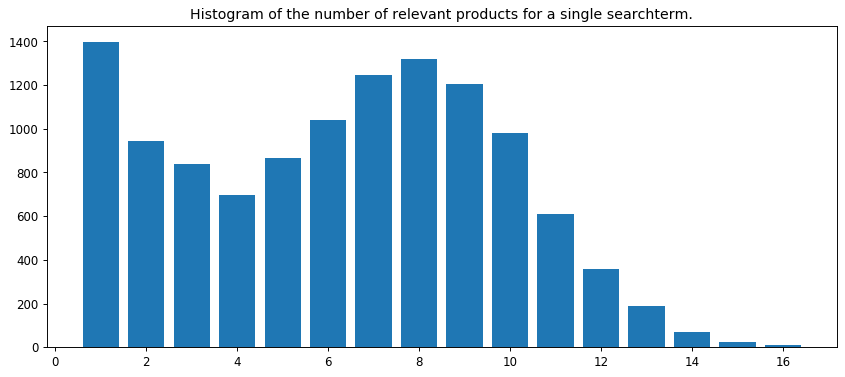
">

---
Используя свои знания `matplotlib` выведите гистограмму количества уникальных значений `relevance` для каждого из доступных запросов.

#### <center>Референсный график</center>
<img src="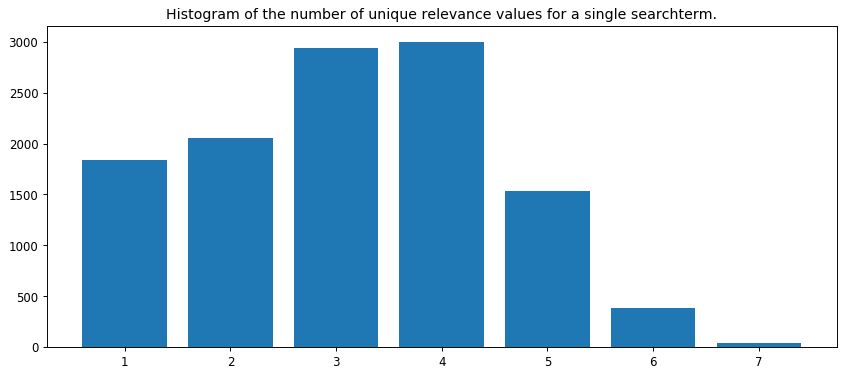
">

### 6. Собственно, машинное обучение

В данном пункте необходимо придумать способ улучшить модель (можно отталкиваться от уже написанной, можно придумать что-то своё).

_Hint_: Данная модель никаким образом не использует данные о релевантности запросов в обучении, возможно стоит это исправить?

**nB!**: До этого разбивать запросы на train-val-test выборки не имело смысла, т.к. при обучении никак не использовались релевантности товаров для данных запросов. Если новая модель будет использовать релевантности товаров, то метрики для сравнения моделей должны быть посчитаны на запросах, истинные ответы к которым ни одна из моделей никогда не видела.

---

Модели оцениваются по nDCG@25 <sup>[1](#ndcg_url)</sup> в предсказанных товарах, а также по коэффициенту [Tau](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient), через который оценивается корреляция предсказанных и истинных рангов товаров.

---
<a name="ndcg_url"><sup>1</sup></a> Определение может быть найдено на 29 странице [PDF](https://web.stanford.edu/class/cs276/handouts/lecture8-evaluation_2014-one-per-page.pdf).

In [18]:
from scipy.stats import kendalltau

_discounts = np.log(np.arange(100) + 2)
def dcg(rel_list, k=25):
    k = min(100, k, len(rel_list))
    rel_list = np.array(rel_list[:k])
    return np.sum(rel_list / _discounts[:k])

def ndcg(topk, rel_dict, k=25):
    idcg = dcg(sorted(rel_dict.values(), reverse=True), k=k)
    if idcg == 0:
        return 0
    relevances = [rel_dict.get(it, 0) for it in topk]
    cur_dcg = dcg(relevances, k=k)
    return cur_dcg / idcg

In [19]:
import warnings

warnings.filterwarnings('ignore')

In [20]:
ndcg_scores = []
tau_scores = []


for search_idx, searchterm in enumerate(tqdm(searches[:len(topk_prediction)], desc='Evaluating model')):
    prediction_idxs = topk_prediction[search_idx][0]
    predicted_products = [index_to_product[idx] for idx in prediction_idxs]
    product_relevances = relevance_dict[searchterm]
    ndcg_scores += [ndcg(predicted_products, product_relevances)]

    products, relevances = zip(*product_relevances.items())
    predicted_relevances = get_relevance(search_idx, products)
    tau_score = kendalltau(relevances, predicted_relevances).correlation
    if tau_score is np.nan:
        tau_scores += [0]
    else:
        tau_scores += [tau_score]

print('Mean nDCG@25: %.03f; mean Tau correlation coefficient: %.03f.' % (
            sum(ndcg_scores) / len(ndcg_scores), sum(tau_scores) / len(tau_scores)))

Evaluating model: 100%|██████████| 400/400 [00:00<00:00, 3148.79it/s]

Mean nDCG@25: 0.034; mean Tau correlation coefficient: 0.063.


In [21]:
# your code here